In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/a-large-scale-fish-dataset/Segmentation_example_script.m
/kaggle/input/a-large-scale-fish-dataset/README.txt
/kaggle/input/a-large-scale-fish-dataset/license.txt
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00033.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00004.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00023.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00041.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00024.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00035.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00045.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00038.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/00025.png
/kaggle/input/a-large-scale-fish-dataset/NA_Fish_Dataset/Black Sea Sprat/0000

# Gerekli kütüphaneleri içe aktarıyoruz.

In [5]:

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt



# Veri setinin yolunu belirtiyoruz.
# Bu kısımda veri setini indirip yerel bir klasöre koymanız gerekecek.

In [10]:
data_dir = '/kaggle/input/a-large-scale-fish-dataset'



# Görüntü boyutu: Görüntüler balık veri setinden geldiği için farklı boyutlara sahip olabilir. 
# Bu yüzden tüm görselleri modelde kullanılabilecek standart bir boyuta getireceğiz.
# Burada 64x64 piksel boyutuna yeniden boyutlandıracağız.

In [6]:
IMG_SIZE = (64, 64)

# ImageDataGenerator ile veri artırma (data augmentation) ve ön işleme işlemlerini yapıyoruz.
# rescale ile görüntüdeki piksel değerlerini [0, 1] aralığına çekiyoruz.
# validation_split parametresi ile veri setini eğitim ve doğrulama seti olarak böleceğiz.

In [7]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Eğitim verisini oluşturuyoruz.
# flow_from_directory, klasör yapısına dayalı veri setlerinde kullanılır.
# Görseller hedef boyuta (64x64) getirilir ve batch_size olarak her adımda 32 görüntü kullanılır.
# class_mode='categorical' ile çok sınıflı bir sınıflandırma yaptığımızı belirtiyoruz.

In [11]:
train_data = datagen.flow_from_directory(data_dir,
                                         target_size=IMG_SIZE,  # Görsellerin boyutlandırılması
                                         batch_size=32,         # Mini batch büyüklüğü
                                         class_mode='categorical',  # Kategorik sınıflandırma (one-hot encoding)
                                         subset='training')     # %80 eğitim verisi

Found 14744 images belonging to 2 classes.



# Doğrulama (validation) verisini oluşturuyoruz.
# Eğitim verisindeki işlemlerin aynısı yapılır ancak 'validation' subset'i kullanılır.

In [12]:
val_data = datagen.flow_from_directory(data_dir,
                                       target_size=IMG_SIZE,   # Aynı boyutlandırma
                                       batch_size=32,          # Aynı batch büyüklüğü
                                       class_mode='categorical',  # Kategorik sınıflandırma
                                       subset='validation')    # %20 doğrulama verisi

Found 3686 images belonging to 2 classes.



# Modeli oluşturma
# Bu aşamada sıralı (Sequential) bir model oluşturuyoruz.
# İlk katmanımız, giriş görüntüsünü vektöre dönüştüren 'Flatten' katmanıdır. 
# 64x64 boyutundaki görüntüleri, her biri 3 kanallı (RGB), düzleştirerek girişe uygun hale getiriyoruz.

In [32]:
model = Sequential([
    Flatten(input_shape=(64, 64, 3)),  # 64x64 boyutlu, 3 kanallı (renkli) görüntüler için input
    Dense(128, activation='relu'),     # 128 nöronlu ve ReLU aktivasyon fonksiyonuna sahip gizli katman
    Dense(64, activation='relu'),      # 64 nöronlu başka bir gizli katman
    Dense(2, activation='softmax')  ])   # 7 sınıf olduğu için, softmax aktivasyonu ile 7 çıkış nöronu

# Modelin derlenmesi (compile edilmesi)
# Optimizer olarak 'adam' kullanıyoruz, bu genellikle iyi performans veren bir optimizasyon algoritmasıdır.
# Loss fonksiyonu olarak 'categorical_crossentropy' kullanılır çünkü çok sınıflı bir sınıflandırma yapıyoruz.
# Ayrıca eğitim sırasında modelin doğruluğunu (accuracy) da takip edeceğiz.

In [33]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# Modeli eğitme (fit)
# Modeli eğitmek için fit fonksiyonunu kullanıyoruz.
# Eğitim ve doğrulama setlerini veriyoruz ve 10 epoch boyunca modelimizi eğitiyoruz.

In [1]:
history = model.fit(train_data, 
                    validation_data=val_data,  # Doğrulama seti
                    epochs=100)                 # Modeli 10 epoch boyunca eğit


NameError: name 'model' is not defined

# Eğitim sonuçlarını görselleştirme
# Eğitim ve doğrulama sırasında elde edilen doğruluk (accuracy) değerlerini plotluyoruz.
# En son epoch'taki doğruluk değerlerini yazdırma

In [36]:
train_acc = history.history['accuracy'][-1]  # Son epoch'taki eğitim doğruluğu
val_acc = history.history['val_accuracy'][-1]  # Son epoch'taki doğrulama doğruluğu

print(f"Son epoch'taki eğitim doğruluğu: {train_acc*100:.2f}%")
print(f"Son epoch'taki doğrulama doğruluğu: {val_acc*100:.2f}%")

Son epoch'taki eğitim doğruluğu: 100.00%
Son epoch'taki doğrulama doğruluğu: 98.64%


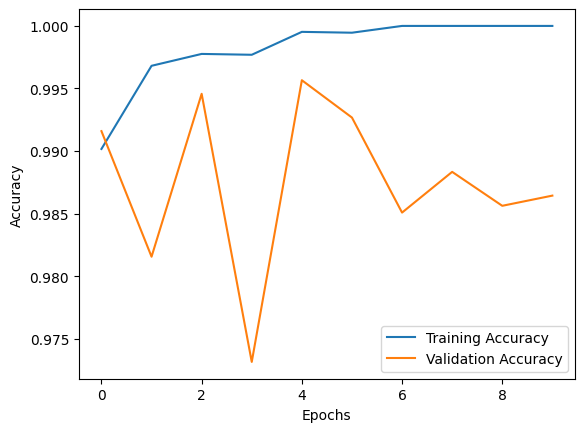

In [35]:
plt.plot(history.history['accuracy'], label='Training Accuracy')  # Eğitim doğruluğu
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  # Doğrulama doğruluğu
plt.xlabel('Epochs')   # X ekseni: Epoch sayısı
plt.ylabel('Accuracy') # Y ekseni: Doğruluk
plt.legend()           # Grafiğin açıklama kısmı (legend)
plt.show()             # Grafiği göster